In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
# from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
# service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
#Useful imports: 
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Operator
from qiskit import *
import numpy as np
from qiskit import QuantumCircuit, execute, BasicAer
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.opflow import I, Z, X

/tmp/ipykernel_61/3333505665.py:9: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import I, Z, X


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

 ## 3.1 Generate a random unitary U by generating a random circuit over $n=5$ qubits with depth$=3$
 You may use QISKIT's built-in function for random circuits: https://qiskit.org/documentation/stable/0.19/stubs/qiskit.circuit.random.random_circuit.html. 
 Visualize your random circuit using **draw(output='mpl')**.

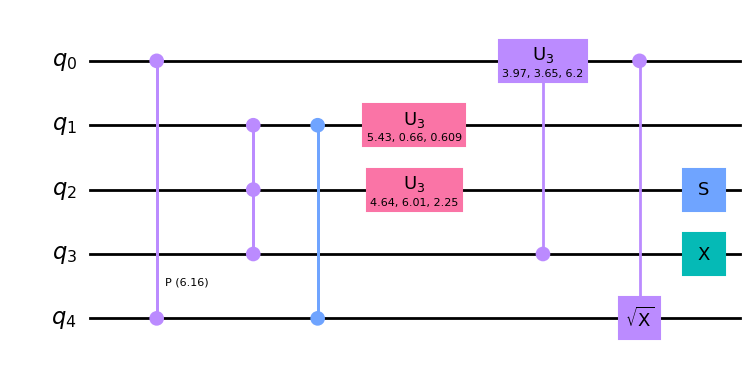

In [4]:
n = 5
depth = 3
random_U = random_circuit(n, depth, measure=False)
random_U.draw(output='mpl')

## 3.2 Compute the trace of the generated random unitary classically. 
For a circuit U, you may use **Operator(U).data** to convert U into a numpy array.

In [5]:
trace = np.trace(Operator(random_U).data)
print('Tr[U]=',trace)

Tr[U]= 0j


## 3.3 Build the circuit for estimating the real part of the trace of U. 
Hint: you may find the following useful: 
**.to_gate()** : https://qiskit.org/documentation/stable/0.39/stubs/qiskit.circuit.QuantumCircuit.to_gate.html

**.control(..)**: https://qiskit.org/documentation/stubs/qiskit.circuit.ControlledGate.html

**.append(..)**: https://qiskit.org/documentation/stable/0.19/stubs/qiskit.circuit.QuantumCircuit.append.html

In [6]:

# Generating the Real part of Trace Estimation Circuit on N qubits:
N = 2*n+1
qr = QuantumRegister(N, 'q')
cr = ClassicalRegister(1, 'c')
circ = QuantumCircuit(qr,cr)
for i in range(n+1):
    circ.h(qr[i])
for i in range(1,n+1):
    circ.cnot(qr[i],qr[i+n])

custom = random_U.to_gate().control(1)

circ.append(custom, [qr[i] for i in range(n+1)])
circ.h(qr[0])
circ.measure(qr[0],cr[0])



#### Draw your estimation circuit: 

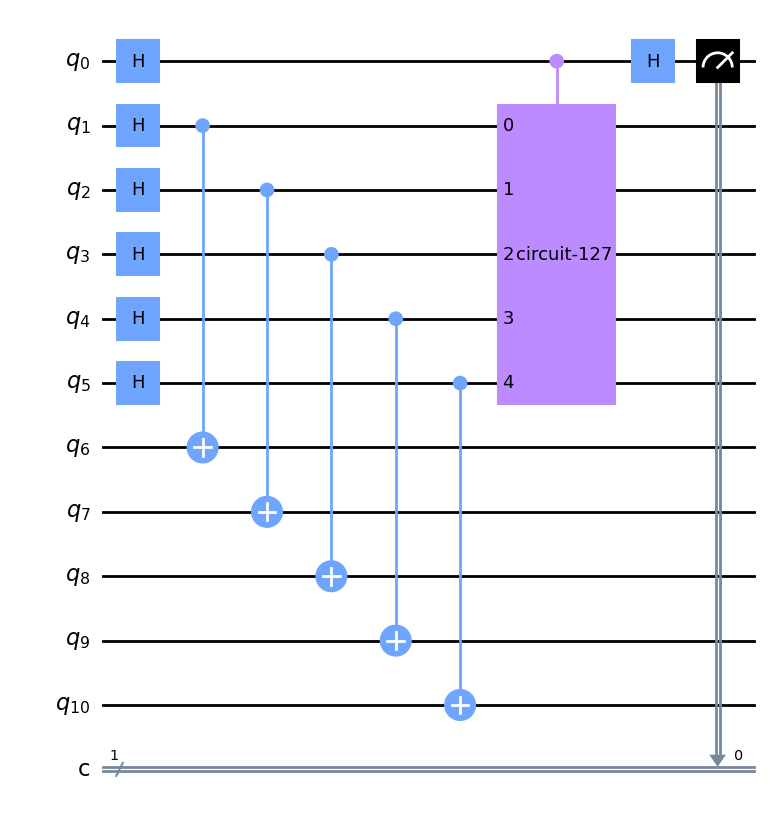

In [7]:
circ.draw(output='mpl')


#### Run your circuit using the 'qasm_simulator'.
Compute the estimate of the trace of the real part from the circuit results.
Compare your estimate with the one computed in question 3.2.
You may change the number of shots till you obtain an accurate result.

In [8]:

backend = BasicAer.get_backend('qasm_simulator')
job = execute(circ, backend, shots=500000)
results = job.result().get_counts()


In [9]:
Probability0 = results['0']/(results['0']+results['1'])
TrEstimate_Real = (Probability0-0.5)*2**n*2
print('Estimate of the real part of the trace=',TrEstimate_Real)

Estimate of the real part of the trace= -0.04236799999999974


In [16]:
def create_real_trace_estimation_circuit(U,n):
    '''
    Args: U: the unitary whose Re{Tr[U]} is to be estimated, 
          n: the number of qubits that U operates on
          
    Returns: Real part of trace estimation circuit
    '''
    N = 2*n+1 # Total number of qubits in the estimation circuit
    
    # create quantum register with N qubits:
    qr = QuantumRegister(N, 'q') 
    
    # create classical register to record the result of measuring a single qubit: 
    cr = ClassicalRegister(1, 'c')
    
    # create the quantum circuit
    circ = QuantumCircuit(qr,cr)
    
    # Apply Hadamard gate to the qubit 0 (from the trace estimation circuit) 
    # and to the next n qubits to prepare the entangled pairs:
    for i in range(n+1):
        circ.h(qr[i])
        
    # Apply CNOT from the qubits 1...n to the qubits n+1...2n to finish the
    # preparation of the entangled pairs.
    for i in range(1,n+1):
        circ.cnot(qr[i],qr[i+n])
    
    # Apply CTRL-U, where the CTRL qubit is the qubit 0, 
    # the target qubits are 1,..,n and U is the unitary
    # whose trace is to be estimated:
    CTRL_U = U.control(1)
    circ.append(CTRL_U, [qr[i] for i in range(n+1)])
    
    # Apply another Hadamard to qubit 0.
    circ.h(qr[0])
    
    # Measure qubit 0 and record the result in the classical register.
    circ.measure(qr[0],cr[0])
    return circ


## 4.1 Generate the unitary $U_{\text{mystery}} = e^{i\theta (X\otimes X)}$ for $\theta = \pi/3$.
Hint: use https://qiskit.org/documentation/stubs/qiskit.circuit.library.PauliEvolutionGate.html 

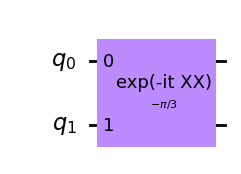

In [17]:

# build the evolution gate
theta = np.pi/3
operator = (X^X) 
evo = PauliEvolutionGate(operator, time=-theta)
 
# plug it into a circuit
circuit = QuantumCircuit(2)
circuit.append(evo, range(2))
circuit.draw()

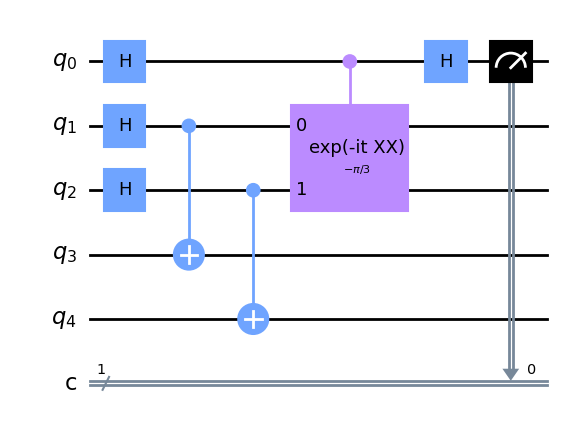

In [18]:
tr_estimation_etXX = create_real_trace_estimation_circuit(evo,2)
tr_estimation_etXX.draw()

## 4.2 Vary $\theta$ from 0 to $\pi/2$. For each value, generate the estimation circuit for the real part of the trace of $U_{\text{mystery}}$. Run your circuit using the QISKIT simulator. Make a plot: on the x-axis: vary $\theta$ from 0 to $\pi/2$, and on the y-axis: your obtained estimate for $\theta$ v.s. $\theta$. 

In [40]:
# vary thetas: 
thetas = np.arange(0,np.pi/2,0.1)

# store estimates of theta in this vector:
estimates = []

for theta in thetas:
    # create U_theta = e^{i theta X X) 
    operator = (X^X) 
    U_theta = PauliEvolutionGate(operator, time=-theta)    
    
    # create real part of trace estimation circuit for U_theta
    tr_estimation_etXX = create_real_trace_estimation_circuit(U_theta,2)
    
    # run the circuit:
    job = execute(tr_estimation_etXX, backend, shots=10000)
    
    # get the results
    results = job.result().get_counts()
    n0 = 0 
    n1 = 0
    if('1' in results.keys()):
        n1 = results['1']
    if('0' in results.keys()):
        n0 = results['0']
        
    # estimate the probability of the outcome 0 from the results
    Probability0 = n0/(n0+n1)
    
    # Compute the estimate of Re{Tr[U_theta]}
    TrEstimate_Real = (Probability0-0.5)*2**2*2
    
    # cos(theta)
    costheta = TrEstimate_Real/4
    
    # estimate = cos^-1(cos(theta))
    estimates.append(np.arccos(costheta))    

Text(0, 0.5, '$\\theta$ estimate')

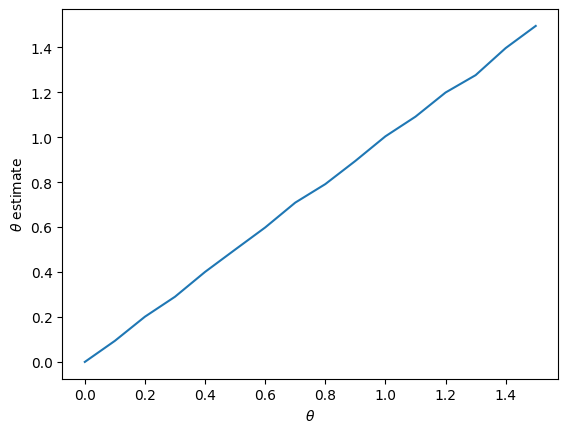

In [44]:
plt.plot(thetas,estimates)
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\theta$ estimate')

# estimate

In [45]:
# n_shots = list(map(int, [1e3, 3e3, 1e4, 3e4, 1e5, 3e5, 1e6, 3e6, 1e7]))
n_shots = [100000, 200000,300000,400000,500000, 600000,700000,800000,900000, 1000000]
results = {}
for ns in n_shots:
    job = execute(circ, backend, shots=ns)
    res = job.result().get_counts()
    results[ns] = res

In [46]:
p_est = np.array([results[ns]['0'] / ns for ns in n_shots])
tr_est = (p_est - 0.5) * 2 ** (n + 1)


In [47]:
p_std_est = np.sqrt(p_est * (1. - p_est)) / np.sqrt(n_shots)
tr_std_est = p_std_est * 2 ** (n + 1)

In [52]:
z = 2.58  # 1.96
z = 1.96
tr_ci_low = tr_est - z * tr_std_est 
tr_ci_up = tr_est + z * tr_std_est 

In [53]:
tr_ci_up - tr_ci_low

array([0.39667365, 0.28049193, 0.22902095, 0.19833805, 0.17739894,
       0.16194228, 0.14992948, 0.14024618, 0.13222504, 0.12543998])

In [54]:
true_tr = trace.real
true_tr

0.0

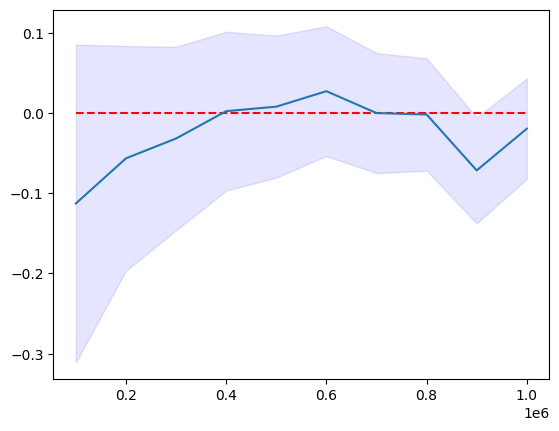

In [56]:

plt.hlines(true_tr, min(n_shots), max(n_shots), color='r', ls='--')
plt.plot(n_shots, tr_est)
plt.fill_between(n_shots, tr_ci_low, tr_ci_up, color='b', alpha=.1)
# plt.xscale('log')